In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
import pandas as pd


ValueError: ignored

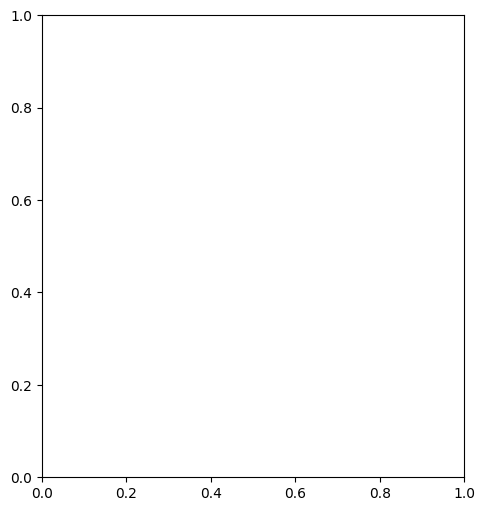

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
#from keras import backend, optimizers


# force channels-first ordering for all loaded images
#backend.set_image_data_format('channels_last')  #The models are designed to use channels first


image_directory = '/content/drive/MyDrive/Colab Notebooks/data/images/'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/data/masks/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpg' or image_name.split('.')[1] == 'jpeg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpg' or image_name.split('.')[1] == 'jpeg'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

#######################################

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
#from focal_loss import BinaryFocalLoss

###############################################################################
#Try various models: Unet, Attention_UNet, and Attention_ResUnet


from keras_unet_collection import models, losses

#############################################################
# Unet Plus
help(models.unet_plus_2d)

model_Unet_plus = models.unet_plus_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=['accuracy', losses.dice_coef])

print(model_Unet_plus.summary())

start2 = datetime.now()

Unet_plus_history = model_Unet_plus.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=150)

stop2 = datetime.now()
#Execution time of the model
execution_time_Unet_plus = stop2-start2
print("UNet plus execution time is: ", execution_time_Unet_plus)

model_Unet_plus.save('/content/drive/MyDrive/Colab Notebooks/data/files/conjun.hdf5')

import pandas as pd
unet_plus_history_df = pd.DataFrame(Unet_plus_history.history)

with open('unet_plus_history_df.csv', mode='w') as f:
    unet_plus_history_df.to_csv(f)


#######################################################################
#Check history plots, one model at a time
history = Unet_plus_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

#######################################################

model = model_Unet_plus

#Load one model at a time for testing.
#model = tf.keras.models.load_model(model, compile=False)


import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    #print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)





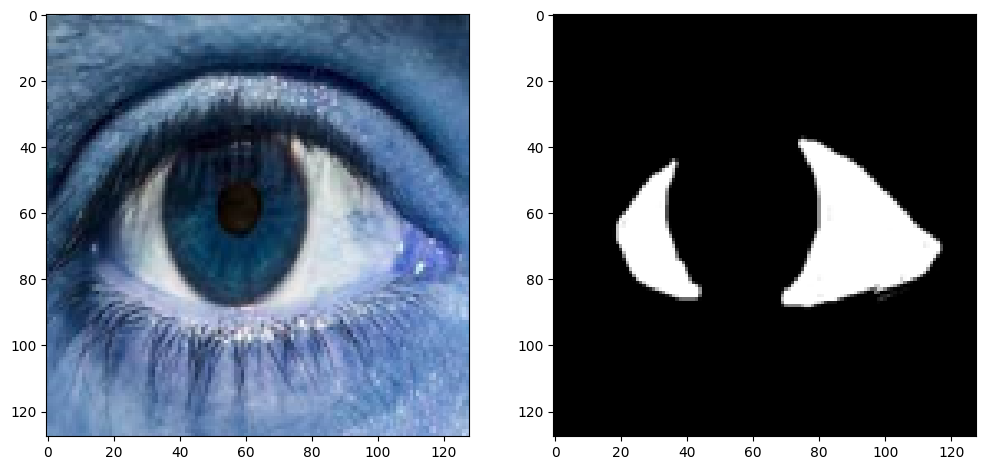

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 VGG16_backbone (Functional  [(None, 128, 128, 64),       1471468   ['input_6[0][0]']             
 )                            (None, 64, 64, 128),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 16, 16, 512),                                                
                              (None, 8, 8, 512)]                                                  
                                                                                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


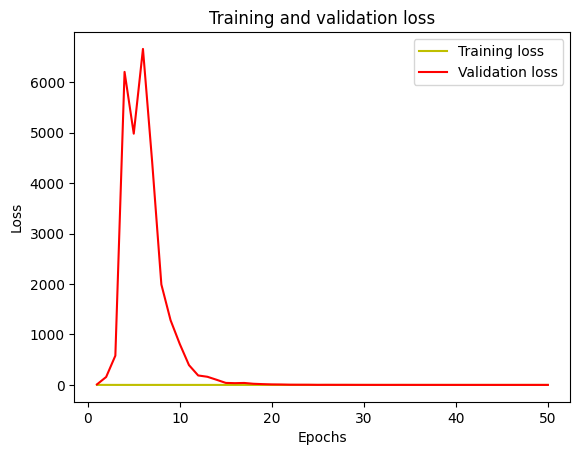

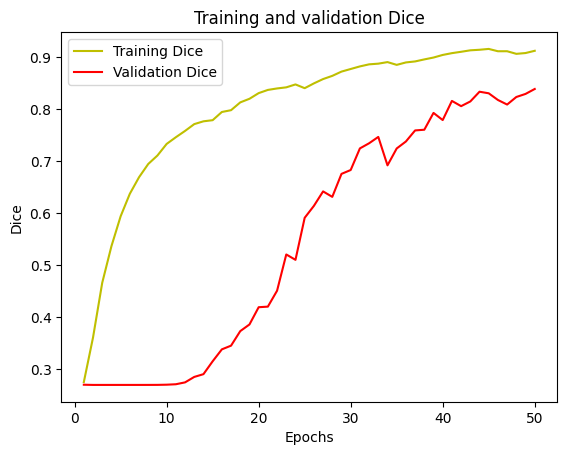

1/1 [==============================] - 0s 417ms/step


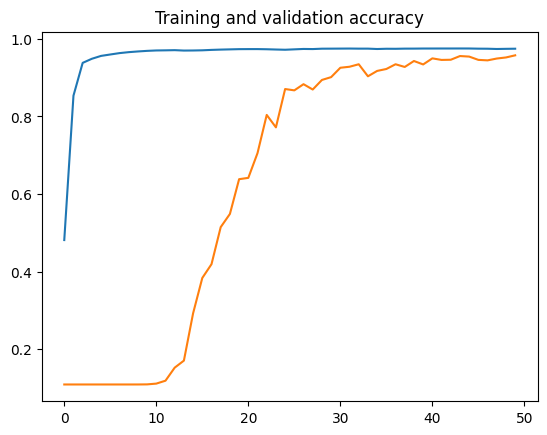

<Figure size 640x480 with 0 Axes>

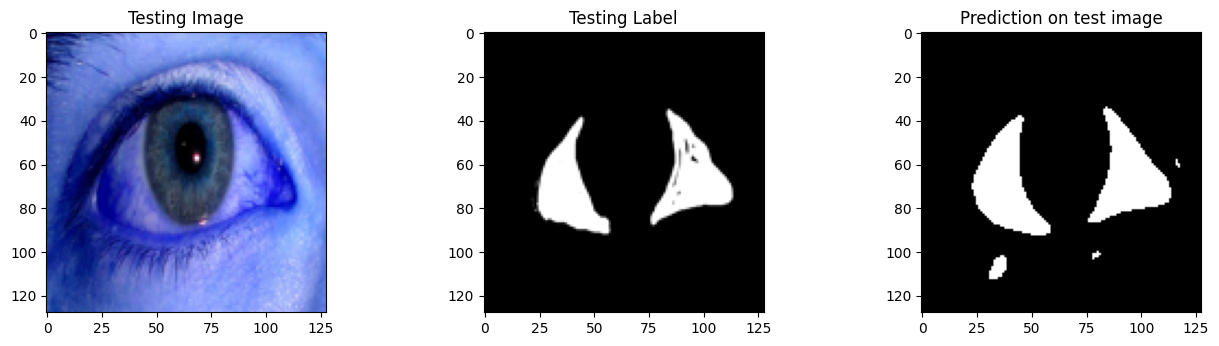

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mean IoU = 0.82505435
1/1 [==============================] - 0s 20ms/step
Mean IoU is:  [0.85323566]


In [ ]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/data/images/'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/data/masks/'

SIZE = 128
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        # print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

  #Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

#######################################

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 5

###############################################################################
#Try various models: Unet, Attention_UNet, and Attention_ResUnet


from keras_unet_collection import models, losses

###############################################################################
#Model 1: Unet with ImageNet trained VGG16 backbone
help(models.unet_2d)

model_Unet = models.unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet')


model_Unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3),
              metrics=['accuracy', losses.dice_coef])

print(model_Unet.summary())

start1 = datetime.now()

Unet_history = model_Unet.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

model_Unet.save('/content/drive/MyDrive/Colab Notebooks/data/files/conjun.hdf5')

# future plotting
import pandas as pd
unet_history_df = pd.DataFrame(Unet_history.history)

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)

#######################################################################
#Check history plots, one model at a time
history = Unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


model = model_Unet

import random
test_img_number = random.randint(0, X_test.shape[0]-1)  #Test with 119

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

import numpy as np
import cv2
from keras.models import load_model

model_Unet.save('/content/drive/MyDrive/Colab Notebooks/data/files/conjun.hdf5')


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    #print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)



In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


1/1 [==============================] - 0s 374ms/step


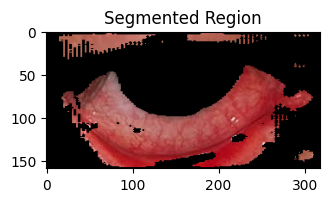

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the U-Net model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/data/files/conjun.hdf5', custom_objects={'dice_coef': dice_coef})

# Load the image you want to segment
input_image_path = '/content/drive/MyDrive/Colab Notebooks/data/images/3.png'  # Replace with the path to your image
original_image = cv2.imread(input_image_path, 1)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB if it's in BGR format

# Preprocess the input image
input_image = cv2.resize(original_image, (SIZE, SIZE))  # Resize to match the model's input size
input_image = input_image / 255.0  # Normalize the image

# Perform image segmentation
segmented_mask = model.predict(np.expand_dims(input_image, axis=0))[0, :, :, 0]
segmented_mask = (segmented_mask > 0.5).astype(np.uint8)

# Resize the segmented mask to match the original image size
segmented_mask = cv2.resize(segmented_mask, (original_image.shape[1], original_image.shape[0]))

# Extract the segmented region from the original image
segmented_region = original_image.copy()
segmented_region[segmented_mask == 0] = 0  # Set non-segmented regions to black

# Display the results
plt.figure(figsize=(12, 6))
# plt.subplot(131)
# plt.imshow(original_image)
# plt.title("Original Image")
# plt.subplot(132)
# plt.imshow(segmented_mask, cmap='gray')
# plt.title("Segmentation Mask")
plt.subplot(133)
plt.imshow(segmented_region)
plt.title("Segmented Region")
plt.show()
